### Imports

In [1]:
from functions.load_data import load_CIFAR_data, load_Google_Digit_Data, load_MNIST_data, shuffle_data
from functions.attacks import attackTestSet, attackTestSetBatch
from functions.models import buildReLuModel, buildTropicalModel
from custom_layers.tropLayers import BimodalBinaryInitializer, BimodalNormalInitializer, Triangular
from tensorflow.keras import losses, initializers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from custom_layers.tropLayers import TropConv2D

In [22]:
x_train, x_test, y_train, y_test = load_MNIST_data(desired_classes=[i for i in range(10)])
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [3]:
x_train, x_test, y_train, y_test = load_CIFAR_data(desired_classes=[i for i in range(10)])
x_train = x_train.reshape(-1,32,32,3)
x_test = x_test.reshape(-1,32,32,3)

In [4]:
x_train.shape

(50000, 32, 32, 3)

In [32]:
model = tf.keras.Sequential([TropConv2D(filters=256, channels=1, window_size = [1, 3, 3, 1], strides = [1, 1, 1, 1]),
                             tf.keras.layers.MaxPooling2D((2, 2)),
                             tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                             tf.keras.layers.MaxPooling2D((2, 2)),
                             tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                             
                             #TropConv2D(filters=64, channels=32, window_size = [1, 3, 3, 1], strides = [1, 1, 1, 1]),
                             #tf.keras.layers.MaxPooling2D((2, 2)),
                             #TropConv2D(filters=64, channels=64, window_size = [1, 3, 3, 1], strides = [1, 1, 1, 1]),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(10, activation='softmax')])
model.compile(optimizer=Adam(0.1), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, verbose=1)
#model.build(input_shape=(32, 28, 28, 1))
#model.summary()

Epoch 1/10
 439/1875 [======>.......................] - ETA: 5:56 - loss: 310.5126 - accuracy: 0.1068

KeyboardInterrupt: 

In [19]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 10s 32ms/step - loss: 157.6044 - accuracy: 0.2014


[157.60443115234375, 0.2013999968767166]

### Testings

In [114]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt

# Create a 32x32x3 image (you can replace this with your actual image)
image = np.random.rand(32, 32, 3)
weights = np.random.rand(64, 3, 3, 3)

window_size = (3, 3, 3)
windowed_views = sliding_window_view(image, window_size)
windowed_views = np.squeeze(sliding_window_view(image, window_size), axis=2)


print(windowed_views[0,0])
print(weights[0])
print(windowed_views[0,0] + weights[0])
print(np.max(windowed_views[0,0] + weights[0]))

'''
plt.imshow(image[0:4, 0:4, :])
plt.title('full')
plt.show()

plt.imshow(windowed_views[0, 0])
plt.title('Chunk 0')
plt.show()
plt.imshow(windowed_views[0, 1])
plt.title('Chunk 0')
plt.show()
'''


[[[0.69366906 0.94685795 0.02108815]
  [0.36370161 0.98882869 0.48854916]
  [0.95750875 0.64567702 0.80602839]]

 [[0.55984893 0.1756384  0.06662328]
  [0.76595684 0.90757629 0.36687542]
  [0.16090179 0.24526181 0.20289152]]

 [[0.02746049 0.85578965 0.55478259]
  [0.17196997 0.42228955 0.60966746]
  [0.05401741 0.29546201 0.72589627]]]
[[[0.17283196 0.57492038 0.13663574]
  [0.96779824 0.36241663 0.87410382]
  [0.99061641 0.78174418 0.08773665]]

 [[0.86856224 0.51373189 0.39827053]
  [0.89005723 0.04602512 0.89372614]
  [0.17940905 0.4216002  0.41465002]]

 [[0.26314494 0.19645442 0.44876782]
  [0.24324112 0.65284644 0.46035446]
  [0.25672059 0.471096   0.52939708]]]
[[[0.86650102 1.52177833 0.15772389]
  [1.33149985 1.35124532 1.36265298]
  [1.94812516 1.4274212  0.89376504]]

 [[1.42841117 0.6893703  0.46489381]
  [1.65601407 0.95360141 1.26060156]
  [0.34031084 0.666862   0.61754154]]

 [[0.29060543 1.05224407 1.00355041]
  [0.4152111  1.07513599 1.07002191]
  [0.310738   0.766558

"\nplt.imshow(image[0:4, 0:4, :])\nplt.title('full')\nplt.show()\n\nplt.imshow(windowed_views[0, 0])\nplt.title('Chunk 0')\nplt.show()\nplt.imshow(windowed_views[0, 1])\nplt.title('Chunk 0')\nplt.show()\n"

In [126]:
import numpy as np

# Create your arrays
small_array = np.random.rand(64, 3, 3, 3)
large_array = np.random.rand(30, 30, 3, 3, 3)

result_addition = large_array + small_array[:, np.newaxis, np.newaxis, :, :, :]
print(result_addition.shape)
# Find the maximum values along the (64, 3, 3, 3) axes
trop_vals = np.max(result_addition, axis=(3,4,5)) - np.min(result_addition, axis=(3,4,5))

# 'max_values' now contains the maximum values for each (64, 3, 3, 3) subarray, and its shape is (30, 30, 64).
print(max_values.shape)

(64, 30, 30, 3, 3, 3)
(64, 30, 30)


In [132]:
import tensorflow as tf
import numpy as np

# Create your arrays
small_array = np.random.rand(64, 3, 3, 3)
large_array = np.random.rand(30, 30, 3, 3, 3)

# Convert NumPy arrays to TensorFlow tensors
small_array_tf = tf.constant(small_array, dtype=tf.float32)
large_array_tf = tf.constant(large_array, dtype=tf.float32)

# Expand dimensions of small_array to match large_array
small_array_expanded = tf.expand_dims(tf.expand_dims(small_array_tf, axis=1), axis=1)

# Perform addition and compute the result
result_addition = large_array_tf + small_array_expanded

# Find the maximum and minimum values along the specified axes
max_vals = tf.reduce_max(result_addition, axis=(3, 4, 5))
min_vals = tf.reduce_min(result_addition, axis=(3, 4, 5))

# Compute the trop_vals
trop_vals = max_vals - min_vals

print(result_addition.shape)
print(trop_vals.shape)


(64, 30, 30, 3, 3, 3)
(64, 30, 30)


In [26]:
import tensorflow as tf

# Create a random input tensor of shape (32, 32, 3)
input_tensor = tf.ones(shape=(32, 28, 28, 1))
weight_tensor = tf.ones(shape=(1, 1, 1, 9, 64))

# Define the window size and strides
window_size = [1, 3, 3, 1]  # [batch_size, height, width, channels]
strides = [1, 1, 1, 1]       # [batch_stride, height_stride, width_stride, channel_stride]

# Use tf.image.extract_patches to create sliding windows
patches = tf.image.extract_patches(images=input_tensor, sizes=window_size, strides=strides, rates=[1, 1, 1, 1], padding='VALID')
print(patches.numpy().shape) 
result_addition = tf.expand_dims(patches, axis=-1) + weight_tensor
print(result_addition.numpy().shape)
max_vals = tf.reduce_max(result_addition, axis=(3))
min_vals = tf.reduce_min(result_addition, axis=(3))

# Compute the trop_vals
trop_vals = max_vals - min_vals
# The result will be a tensor containing the extracted patches
print(trop_vals.shape)

 # The shape of the resulting patches tensor


(32, 26, 26, 9)
(32, 26, 26, 9, 64)
(32, 26, 26, 64)


In [27]:
weight_tensor

<tf.Tensor: shape=(1, 1, 1, 9, 64), dtype=float32, numpy=
array([[[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1.],
      

In [37]:
tuppp = (1, 2, 3)
print(tuppp[0])
print(tuppp[1])
print(tuppp[2])


1
2
3


### MNIST, all numbers PGD test

In [9]:
iterations = 1
loss_object = losses.CategoricalCrossentropy()
x_train, x_test, y_train, y_test = load_MNIST_data(desired_classes=[i for i in range(10)])
tests = [(buildReLuModel, initializers.RandomNormal(mean=0.5, stddev=1., seed=0), "ReLU"),
         (buildTropicalModel, BimodalNormalInitializer(stddev=1,high=5.5, low=-4.5), "Tropical ~N(-4.5,1) or ~N(5.5,1)")]

for i in range(iterations):
    print(f'================\n\t{i}\n================')
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test) 
    data = []
    for model, intializer_w, name in tests:
        built_model = model(x_train, y_train, num_epochs=10, initializer_w=intializer_w, verbose = 1,
                            second_layer_size = 10, second_layer_activation = 'sigmoid', training_loss = 'categorical_crossentropy')
        x_test_att = attackTestSetBatch(built_model, x_test, y_test, loss_object, name)
        pre_loss, pre_acc = built_model.evaluate(x_test, y_test)
        post_loss, post_acc = built_model.evaluate(x_test_att, y_test)
        data.extend([pre_loss, pre_acc, post_loss, post_acc])
    with open('MNIST_Simple_All_Test.csv', 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

	0
Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 8.7630 - accuracy: 0.8526
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5664 - accuracy: 0.8685
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.9688 - accuracy: 0.7479
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2548 - accuracy: 0.6249
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.3360 - accuracy: 0.5863
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.3141 - accuracy: 0.5941
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2625 - accuracy: 0.6014
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2318 - accuracy: 0.6173
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2497 - accuracy: 0.6181
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


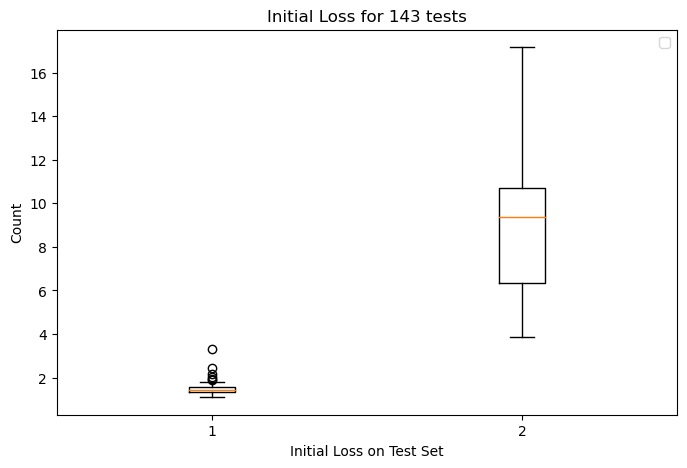

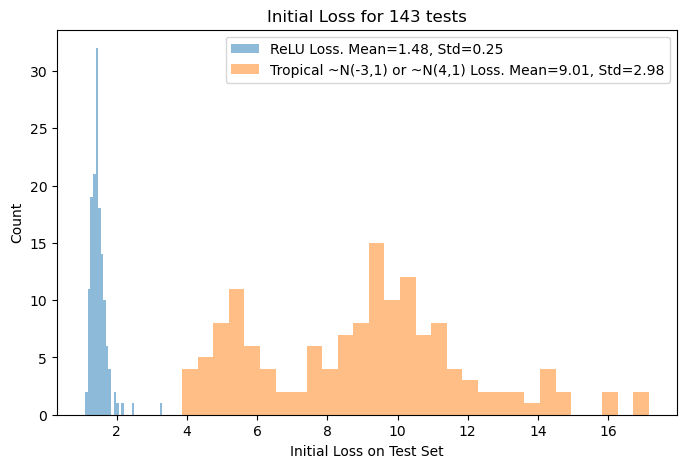

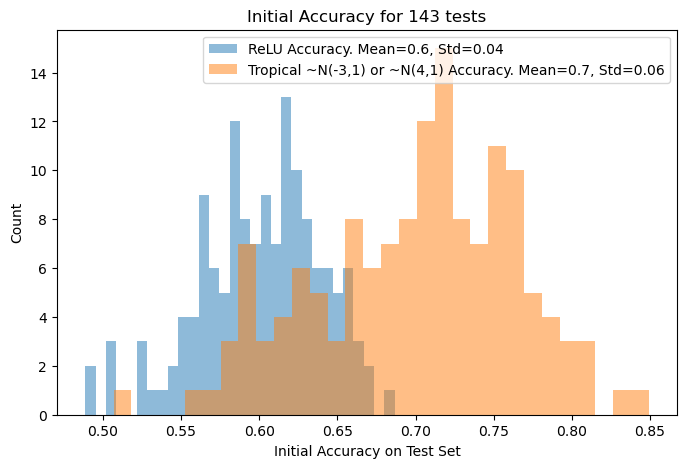

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


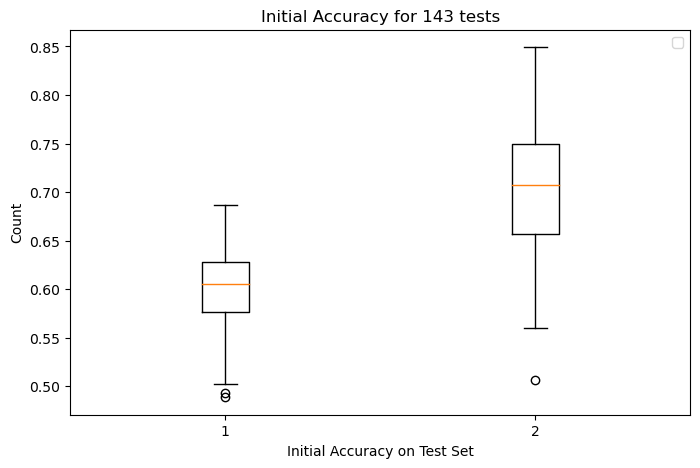

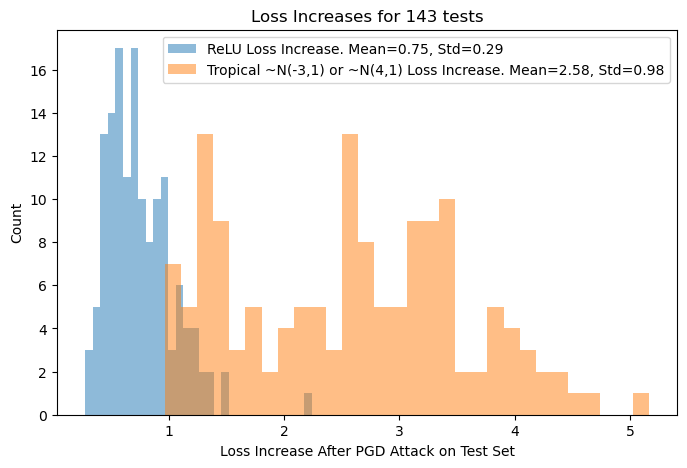

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


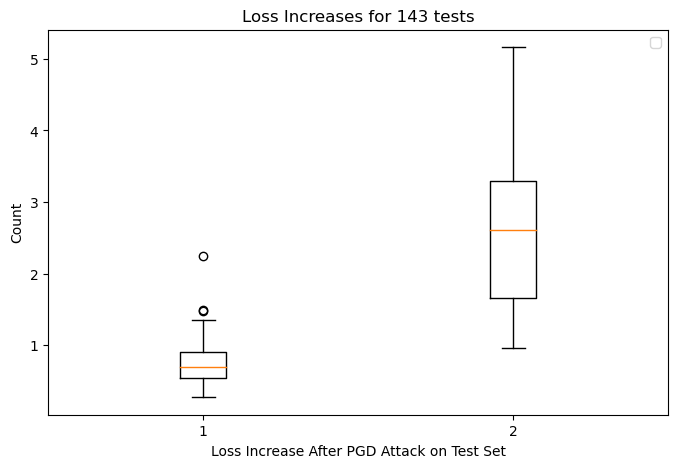

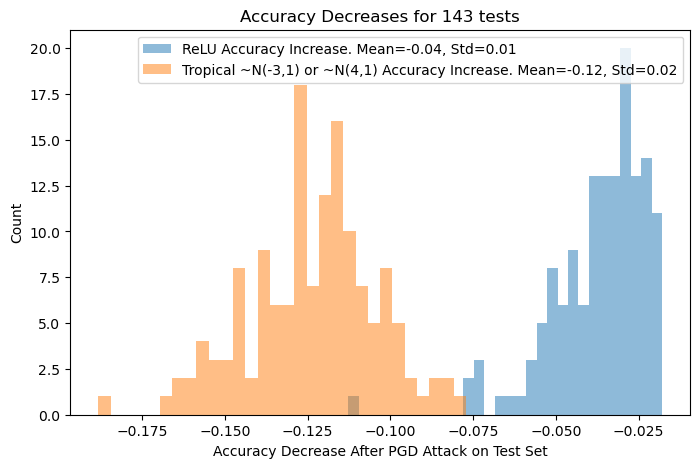

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


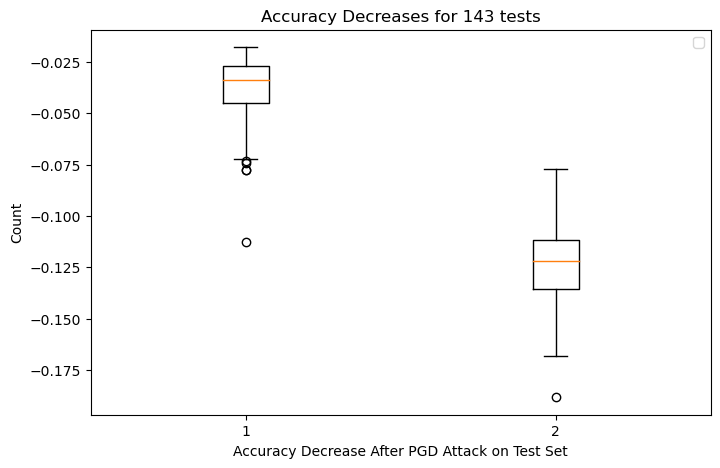

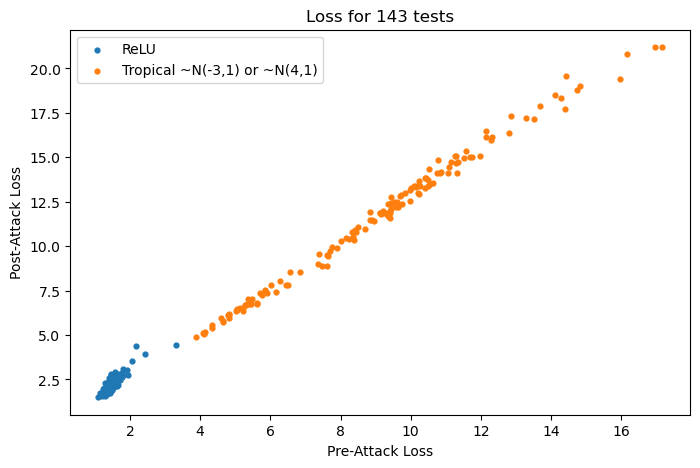

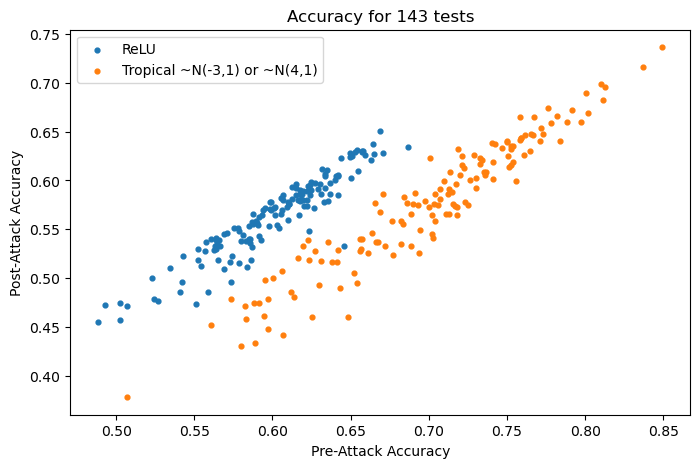

In [7]:
scat_size = 12
bin_num = 30
hist_wid = 8
hist_hei = 5
data = pd.read_csv("MNIST_Simple_All_Test.csv")
rowNum = data.shape[0]

data["relu_loss_diff"] = data['relu_post_loss'] - data['relu_pre_loss']
data["relu_acc_diff"] = data['relu_post_acc'] - data['relu_pre_acc']

data["trop_loss_diff"] = data['trop_post_loss'] - data['trop_pre_loss']
data["trop_acc_diff"] = data['trop_post_acc'] - data['trop_pre_acc']

columns = ["relu_pre_loss", "trop_pre_loss"]
settings = ["ReLU","Tropical ~N(-3,1) or ~N(4,1)"]

plt.figure(figsize=(hist_wid,hist_hei))
plt.boxplot(np.array(data[columns]))
plt.xlabel('Initial Loss on Test Set')
plt.ylabel('Count')
plt.title(f'Initial Loss for {rowNum} tests')
plt.legend()
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
for i in range(len(columns)):
    plt.hist(np.array(data[columns[i]]), bins=bin_num, alpha=0.5, label=f'{settings[i]} Loss. Mean={round(data[columns[i]].mean(),2)}, Std={round(data[columns[i]].std(),2)}')
plt.xlabel('Initial Loss on Test Set')
plt.ylabel('Count')
plt.title(f'Initial Loss for {rowNum} tests')
plt.legend()
plt.show()

columns = ["relu_pre_acc", "trop_pre_acc"]
plt.figure(figsize=(hist_wid,hist_hei))
for i in range(len(columns)):
    plt.hist(np.array(data[columns[i]]), bins=bin_num, alpha=0.5, label=f'{settings[i]} Accuracy. Mean={round(data[columns[i]].mean(),2)}, Std={round(data[columns[i]].std(),2)}')
plt.xlabel('Initial Accuracy on Test Set')
plt.ylabel('Count')
plt.title(f'Initial Accuracy for {rowNum} tests')
plt.legend()
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
plt.boxplot(np.array(data[columns]))
plt.xlabel('Initial Accuracy on Test Set')
plt.ylabel('Count')
plt.title(f'Initial Accuracy for {rowNum} tests')
plt.legend()
plt.show()

columns = ["relu_loss_diff", "trop_loss_diff"]
plt.figure(figsize=(hist_wid,hist_hei))
for i in range(len(columns)):
    plt.hist(np.array(data[columns[i]]), bins=bin_num, alpha=0.5, label=f'{settings[i]} Loss Increase. Mean={round(data[columns[i]].mean(),2)}, Std={round(data[columns[i]].std(),2)}')
plt.xlabel('Loss Increase After PGD Attack on Test Set')
plt.ylabel('Count')
plt.title(f'Loss Increases for {rowNum} tests')
plt.legend()
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
plt.boxplot(np.array(data[columns]))
plt.xlabel('Loss Increase After PGD Attack on Test Set')
plt.ylabel('Count')
plt.title(f'Loss Increases for {rowNum} tests')
plt.legend()
plt.show()

columns = ["relu_acc_diff", "trop_acc_diff"]
plt.figure(figsize=(hist_wid,hist_hei))
for i in range(len(columns)):
    plt.hist(np.array(data[columns[i]]), bins=bin_num, alpha=0.5, label=f'{settings[i]} Accuracy Increase. Mean={round(data[columns[i]].mean(),2)}, Std={round(data[columns[i]].std(),2)}')
plt.xlabel('Accuracy Decrease After PGD Attack on Test Set')
plt.ylabel('Count')
plt.title(f'Accuracy Decreases for {rowNum} tests')
plt.legend()
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
plt.boxplot(np.array(data[columns]))
plt.xlabel('Accuracy Decrease After PGD Attack on Test Set')
plt.ylabel('Count')
plt.title(f'Accuracy Decreases for {rowNum} tests')
plt.legend()
plt.show()

columns1 = ["relu_pre_loss", "trop_pre_loss"]
columns2 = ["relu_post_loss", "trop_post_loss"]
plt.figure(figsize=(hist_wid,hist_hei))
for i in range(len(columns)):
    plt.scatter(data[columns1[i]], data[columns2[i]], s=scat_size, label=settings[i])
plt.xlabel('Pre-Attack Loss')
plt.ylabel('Post-Attack Loss')
plt.title(f'Loss for {rowNum} tests')
plt.legend()
plt.show()

columns1 = ["relu_pre_acc", "trop_pre_acc"]
columns2 = ["relu_post_acc", "trop_post_acc"]
plt.figure(figsize=(hist_wid,hist_hei))
for i in range(len(columns)):
    plt.scatter(data[columns1[i]], data[columns2[i]], s=scat_size, label=settings[i])
plt.xlabel('Pre-Attack Accuracy')
plt.ylabel('Post-Attack Accuracy')
plt.title(f'Accuracy for {rowNum} tests')
plt.legend()
plt.show()
